<a href="https://colab.research.google.com/github/drewharris0103/Machine_Learning/blob/main/Bikes/fcc_bikes_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

#Data Set
 https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand

In [100]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"] #"seasons", "holiday", ""
df = pd.read_csv("SeoulBikeData_fixed.csv").drop(["Date","Holiday","Seasons"], axis=1)

In [101]:
df.columns = dataset_cols
df["functional"] = (df["functional"]=="Yes").astype(int)
df = df[df["hour"] == 12]#.drop("hour")
df = df.drop("hour", axis=1)

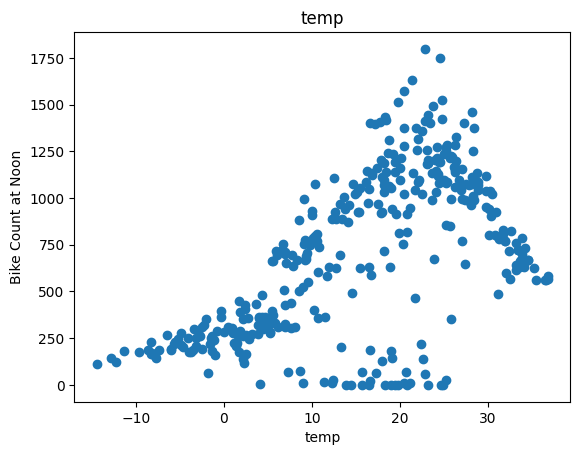

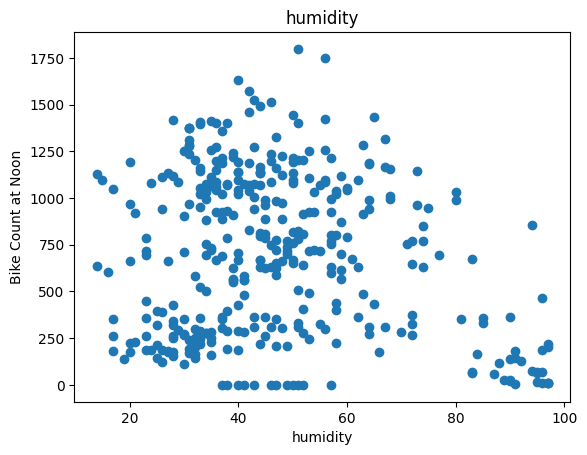

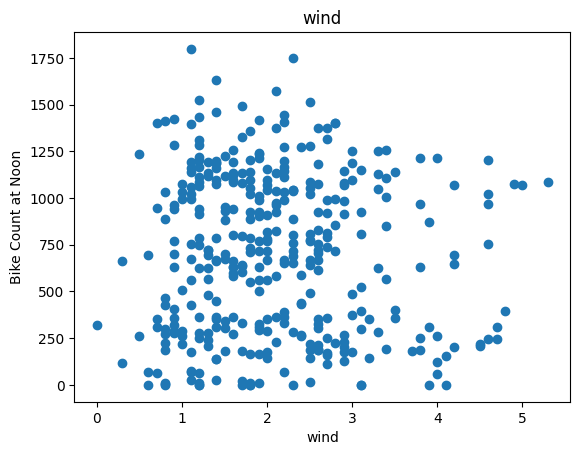

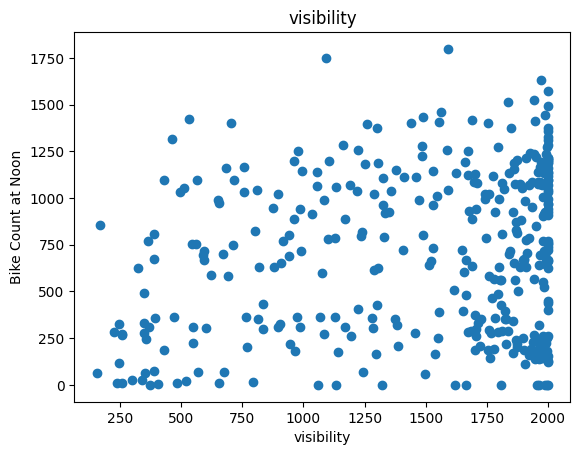

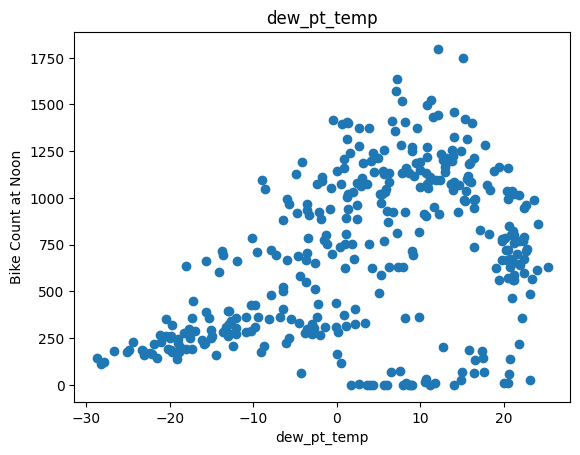

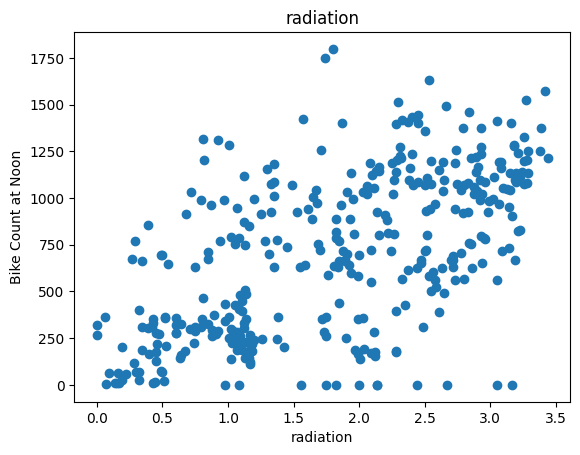

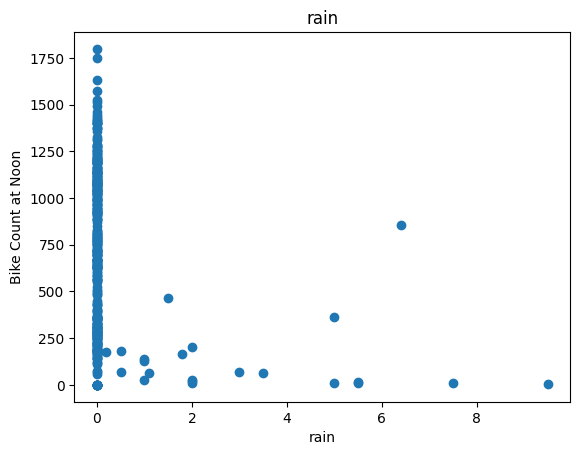

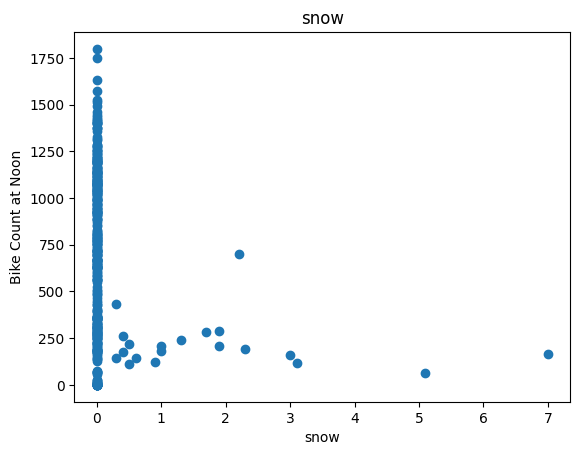

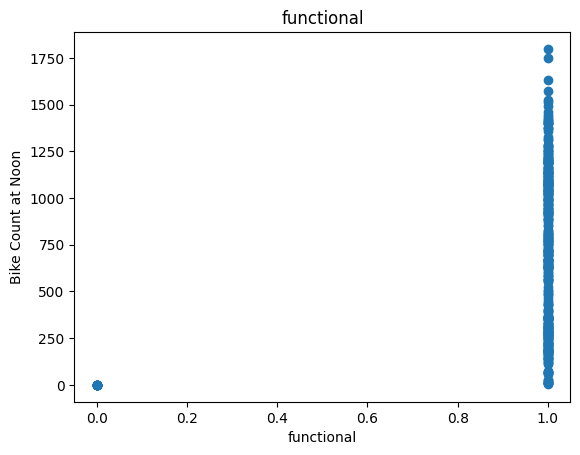

In [102]:
for label in df.columns[1:]: #everything after the first column
  plt.scatter(df[label],df["bike_count"])
  plt.title(label)
  plt.ylabel("Bike Count at Noon")
  plt.xlabel(label)
  plt.show()

In [103]:
df.drop(["wind", "visibility", "functional"], axis = 1, inplace=True)

In [104]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


#Train/valid/test dataset

In [105]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


^^^ sampling data by mixing, frac = 1 means 100% of data being split, cut in groups of 0 - 60%, 60 - 80%, 80 - 100% (of the mixed data)

In [106]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    x = dataframe[[c for c in dataframe.columns if c != y_label]].values
  else:
    if len(x_labels) == 1:
      x = dataframe[x_labels[0]].values.reshape(-1,1)
    else:
      x = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1,1)
  data = np.hstack((x,y))

  return data, x, y

In [107]:
_, x_train_temp, y_train_temp = get_xy(train, "bike_count",x_labels=["temp"])
_, x_val_temp, y_val_temp = get_xy(val, "bike_count",x_labels=["temp"])
_, x_test_temp, y_test_temp = get_xy(test, "bike_count",x_labels=["temp"])


^^^^ splitting data sets (train, valid, test) into x and y dataframes: y values, x values

In [108]:
temp_reg = LinearRegression()
temp_reg.fit(x_train_temp, y_train_temp) #TRAINING MODEL

LinearRegression()

In [109]:
temp_reg.score(x_test_temp, y_test_temp) #closer to 1 is better

0.31116857530533404

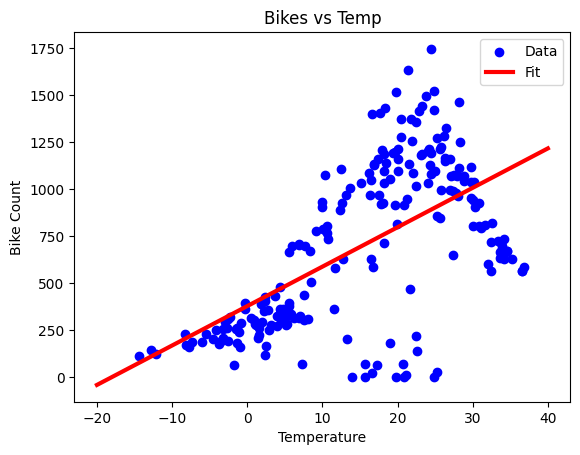

In [110]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Bike Count")
plt.xlabel("Temperature")
plt.show()

#Multiple Linear Regression

In [111]:
_, x_train_all, y_train_all = get_xy(train, "bike_count")
_, x_val_all, y_val_all = get_xy(val, "bike_count")
_, x_test_all, y_test_all = get_xy(test, "bike_count")

In [112]:
all_reg = LinearRegression()
all_reg.fit(x_train_all, y_train_all)

LinearRegression()

In [113]:
all_reg.score(x_test_all, y_test_all)

0.37919856934765517

In [114]:
y_pred_lr = all_reg.predict(x_test_all)

# Regression with Neural Net

In [115]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [116]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [117]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [118]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [120]:
history = temp_nn_model.fit(
  x_train_temp.reshape(-1), y_train_temp.reshape(-1),
  verbose=0,
  epochs=1000,
  validation_data=(x_val_temp, y_val_temp),
)

In [121]:
history.history

{'loss': [178864.4375,
  178596.625,
  178341.75,
  178088.9375,
  177840.953125,
  177581.234375,
  177332.734375,
  177090.734375,
  176833.875,
  176596.5,
  176344.0,
  176082.09375,
  175838.09375,
  175597.8125,
  175365.875,
  175098.5,
  174873.8125,
  174613.109375,
  174380.875,
  174134.46875,
  173902.09375,
  173644.578125,
  173411.3125,
  173171.5625,
  172928.65625,
  172698.875,
  172464.46875,
  172231.421875,
  171990.765625,
  171758.46875,
  171517.046875,
  171286.359375,
  171059.0,
  170814.578125,
  170598.8125,
  170354.015625,
  170133.703125,
  169898.765625,
  169673.859375,
  169440.1875,
  169214.09375,
  168985.875,
  168759.421875,
  168530.703125,
  168303.109375,
  168087.71875,
  167851.546875,
  167637.1875,
  167407.96875,
  167189.921875,
  166961.859375,
  166742.09375,
  166518.6875,
  166306.375,
  166080.546875,
  165868.75,
  165653.515625,
  165423.765625,
  165212.78125,
  164992.546875,
  164789.328125,
  164565.3125,
  164347.75,
  164149

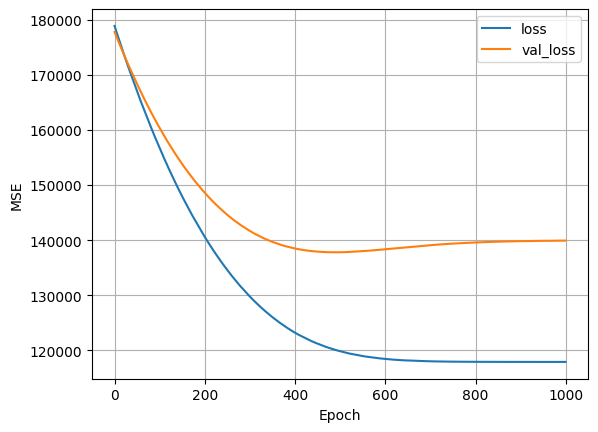

In [122]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


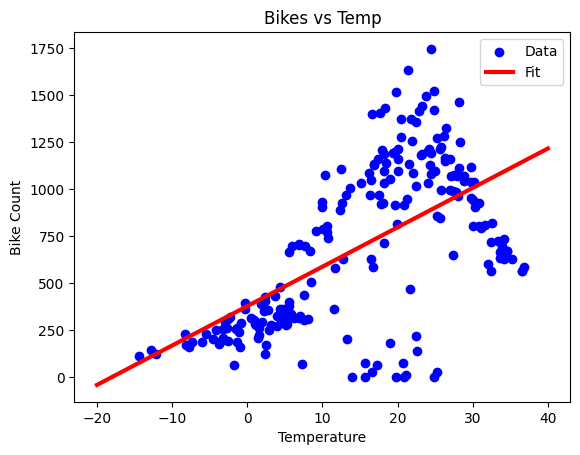

In [123]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Bike Count")
plt.xlabel("Temperature")
plt.show()

#Neural Net


In [133]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(x_train_all)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [134]:
nn_model = tf.keras.Sequential([
      all_normalizer,
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(1)
  ])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [126]:
print(x_train_all.shape)

(219, 6)


In [128]:
nn_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_9 (Normalization) │ (None, 9)              │            13 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,478 (9.68 KB)

 Trainable params: 2,465 (9.63 KB)

 Non-trainable params: 13 (56.00 B)

In [129]:
print(x_train_all.shape)

(219, 6)


In [135]:
history = nn_model.fit(
    x_train_all, y_train_all,
    validation_data=(x_val_all, y_val_all),
    verbose=0,
    epochs=100
)

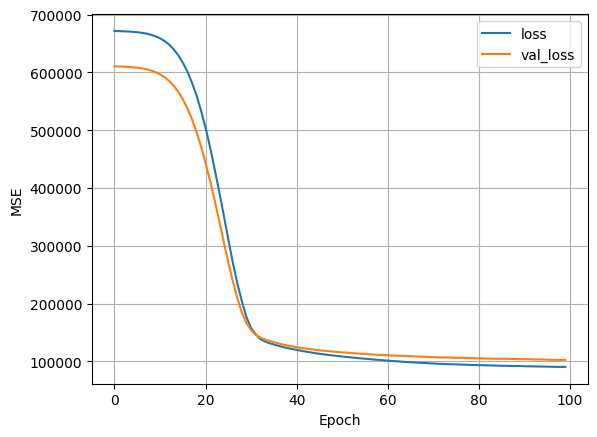

In [136]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


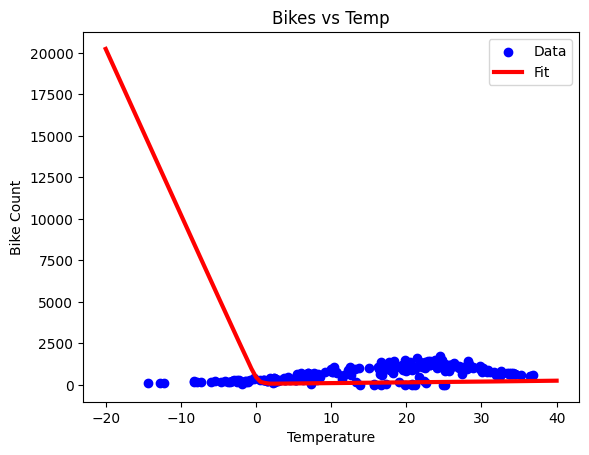

In [137]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Bike Count")
plt.xlabel("Temperature")
plt.show()

In [138]:
# calculate the MSE for both linear reg and nn
y_pred_lr = all_reg.predict(x_test_all)
y_pred_nn = nn_model.predict(x_test_all)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [139]:
def MSE(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()

In [142]:
MSE(y_pred_lr, y_test_all)

np.float64(112989.7808987769)

In [140]:
MSE(y_pred_nn, y_test_all)

np.float64(116383.35705228549)

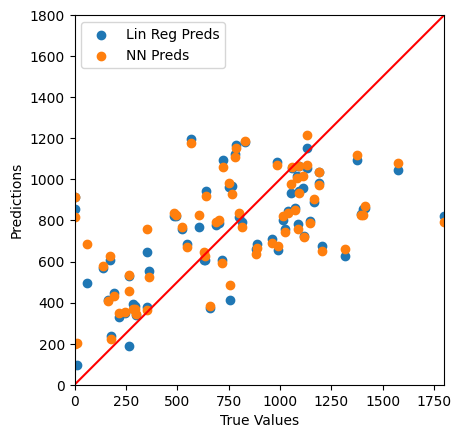

In [145]:
ax = plt.axes(aspect='equal')
plt.scatter(y_test_all, y_pred_lr, label='Lin Reg Preds')
plt.scatter(y_test_all, y_pred_nn, label='NN Preds')
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c='red')